# Deep Learning Model for Drug-Target Binding Affinity Prediction

## Installing and importing packages

In [ ]:
# Uncomment and run for CPU run
#!pip install tensorflow

In [1]:
# Uncomment and run for GPU run
#!pip install tensorflow[and-cuda]
#!pip install nvidia-cudnn-cu11==8.6.0.163

Looking in indexes: https://repo.nferx.com/repository/pypi-all/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 217.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 121.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 127.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 168.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 167.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 175.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 223.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 82.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 132.5 MB/s eta 0:00:00a 0:00:01


In [2]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import csv
import random
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

2023-10-25 09:29:59.680750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 09:29:59.680818: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 09:29:59.680862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 09:29:59.691785: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Importing the cleaned KiBA dataset

In [3]:
all_dt_df = pd.read_excel('KiBA_dataset.xlsx')
all_dt_df.head(3)

,Ligand,Ligand_SMILES,Protein,Protein_Seq,KiBA_Score
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,O00238,MLLRSAGKLNVGTKKEDGESTAPTPRPKVLRCKCHHHCPEDSVNNI...,3.518514
1,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,O00311,MEASLGIQMDEPMAFSPQRDRFQAEGSLKKNEQNFKLAGVKKDIEK...,3.100002
2,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,O00329,MPPGVDCPMEFWTKEENQSVVVDFLLPTGVYLNFPVSRNANLSTIK...,4.000000


In [4]:
all_dt_df['SMILES_len'] = [len(i) for i in all_dt_df['Ligand_SMILES']] #Saving length of each SMILES in a separate column
all_dt_df['Seq_len'] = [len(i) for i in all_dt_df['Protein_Seq']] #Saving length of each Protein sequence in a separate column
all_dt_df.head(3)

,Ligand,Ligand_SMILES,Protein,Protein_Seq,KiBA_Score,SMILES_len,Seq_len
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,O00238,MLLRSAGKLNVGTKKEDGESTAPTPRPKVLRCKCHHHCPEDSVNNI...,3.518514,57,502
1,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,O00311,MEASLGIQMDEPMAFSPQRDRFQAEGSLKKNEQNFKLAGVKKDIEK...,3.100002,57,574
2,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,O00329,MPPGVDCPMEFWTKEENQSVVVDFLLPTGVYLNFPVSRNANLSTIK...,4.000000,57,1044


In [5]:
all_dt_df['SMILES_len'].describe()

count    240993.000000
mean         49.928878
std          17.515666
min           2.000000
25%          41.000000
50%          48.000000
75%          57.000000
max         694.000000
Name: SMILES_len, dtype: float64

In [6]:
all_dt_df['SMILES_len'].quantile(0.95)

72.0

In [7]:
all_dt_df['Seq_len'].describe()

count    240993.000000
mean        755.094306
std         442.899389
min         115.000000
25%         424.000000
50%         626.000000
75%        1038.000000
max        4128.000000
Name: Seq_len, dtype: float64

In [8]:
all_dt_df['Seq_len'].quantile(0.95)

1382.0

In [9]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Distribution of Ligand-SMILES length in the KiBA dataset')

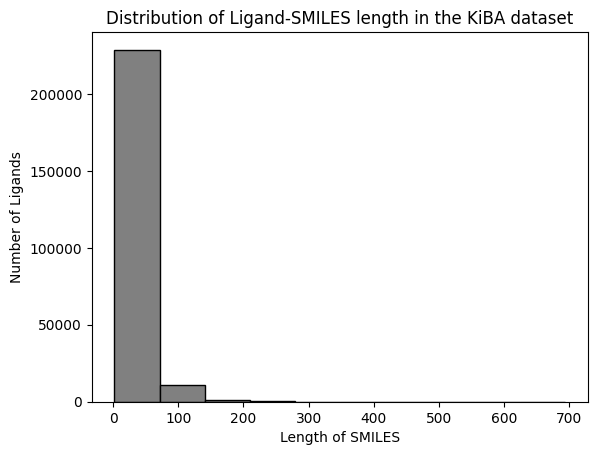

In [10]:
plt.hist(all_dt_df['SMILES_len'],color='gray',edgecolor='black')
plt.xlabel('Length of SMILES')
plt.ylabel('Number of Ligands')
plt.title('Distribution of Ligand-SMILES length in the KiBA dataset')

Text(0.5, 1.0, 'Distribution of Protein Sequence length in the KiBA dataset')

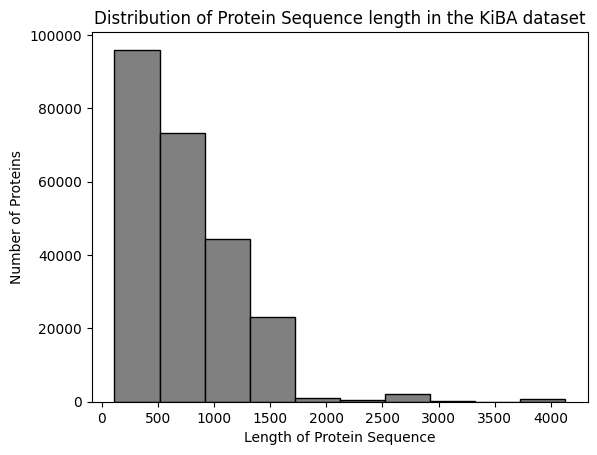

In [11]:
plt.hist(all_dt_df['Seq_len'],color='gray',edgecolor='black')
plt.xlabel('Length of Protein Sequence')
plt.ylabel('Number of Proteins')
plt.title('Distribution of Protein Sequence length in the KiBA dataset')

In [12]:
all_dt_df = all_dt_df.sample(frac=1).reset_index(drop=True) #Random shuffling of the dataset
data = all_dt_df[['Ligand_SMILES','Protein_Seq','KiBA_Score']].values.tolist()
len(data) #Total interaction informations available

240993

In [13]:
smiles = all_dt_df['Ligand_SMILES'].tolist()
proteins = all_dt_df['Protein_Seq'].tolist()
labels = all_dt_df['KiBA_Score'].tolist()

In [14]:
print(f'Total number of unique proteins: {len(set(proteins))}')
print(f'Total number of unique ligands: {len(set(smiles))}')

Total number of unique proteins: 467
Total number of unique ligands: 51555


In [15]:
# Splitting the dataset into training and test data (80-20 split commonly used)
split_percentage = int(input('Enter training-test data split percentage:'))

Enter training-test data split percentage: 80


In [16]:
split = int(split_percentage/100 * len(smiles))
train_smiles, train_proteins, train_labels = smiles[:split],proteins[:split],labels[:split]
test_smiles, test_proteins, test_labels = smiles[split:],proteins[split:],labels[split:]

In [17]:
max_smiles_len = all_dt_df['SMILES_len'].quantile(0.95) #SMILES length covering 95% of the ligands
max_seq_len = all_dt_df['Seq_len'].quantile(0.95) #Sequence length covering 95% of the proteins

## Preprocessing Ligand SMILES

In [18]:
# Assigning an integer value to each unique SMILES character in the dataset
tokenizer_smiles = Tokenizer(char_level=True,lower=False)
tokenizer_smiles.fit_on_texts(smiles)

In [19]:
word_index_smiles = tokenizer_smiles.word_index
vocab_size_smiles = len(word_index_smiles)

In [20]:
print(word_index_smiles)
print(vocab_size_smiles)

{'c': 1, 'C': 2, '(': 3, ')': 4, '1': 5, '2': 6, 'n': 7, 'O': 8, 'N': 9, '3': 10, '=': 11, '4': 12, '-': 13, '[': 14, ']': 15, 'H': 16, 'F': 17, '@': 18, 'l': 19, '5': 20, 's': 21, 'S': 22, '/': 23, '#': 24, 'o': 25, 'B': 26, 'r': 27, '6': 28, '\\': 29, '+': 30, '.': 31, 'I': 32, 'P': 33, '7': 34, '8': 35, 'a': 36, 'e': 37, 'K': 38, 'i': 39, 'A': 40, '9': 41, 'Z': 42, 'L': 43}
43


In [21]:
# Label encoding the SMILES data and truncating/padding them so that all of them have a uniform length
train_sequences_smiles = tokenizer_smiles.texts_to_sequences(train_smiles)
train_padded_smiles = pad_sequences(train_sequences_smiles,truncating="post",padding="post",maxlen=int(max_smiles_len))

test_sequences_smiles = tokenizer_smiles.texts_to_sequences(test_smiles)
test_padded_smiles = pad_sequences(test_sequences_smiles,truncating="post",padding="post",maxlen=int(max_smiles_len))

## Preprocessing Protein Sequences

In [22]:
# Assigning an integer value to each unique aminoacid in the dataset
tokenizer_proteins = Tokenizer(char_level=True,lower=False)
tokenizer_proteins.fit_on_texts(proteins)

In [23]:
word_index_proteins = tokenizer_proteins.word_index
vocab_size_proteins = len(word_index_proteins)

In [24]:
print(word_index_proteins)
print(vocab_size_proteins)

{'L': 1, 'S': 2, 'E': 3, 'G': 4, 'V': 5, 'K': 6, 'A': 7, 'P': 8, 'R': 9, 'D': 10, 'T': 11, 'I': 12, 'Q': 13, 'N': 14, 'F': 15, 'Y': 16, 'H': 17, 'M': 18, 'C': 19, 'W': 20}
20


In [25]:
# Label encoding the Protein sequences data and truncating/padding them so that all of them have a uniform length
train_sequences_proteins = tokenizer_proteins.texts_to_sequences(train_proteins)
train_padded_proteins = pad_sequences(train_sequences_proteins,truncating="post",padding="post",maxlen=int(max_seq_len))

test_sequences_proteins = tokenizer_proteins.texts_to_sequences(test_proteins)
test_padded_proteins = pad_sequences(test_sequences_proteins,truncating="post",padding="post",maxlen=int(max_seq_len))

In [26]:
# Coverting all lists to numpy arrays
train_smiles_array = np.array(train_padded_smiles)
test_smiles_array = np.array(test_padded_smiles)
train_proteins_array = np.array(train_padded_proteins)
test_proteins_array = np.array(test_padded_proteins)
train_labels_array = np.array(train_labels)
test_labels_array = np.array(test_labels)

print(train_smiles_array.shape)
print(test_smiles_array.shape)
print(train_proteins_array.shape)
print(test_proteins_array.shape)
print(train_labels_array.shape)
print(test_labels_array.shape)

(192794, 72)
(48199, 72)
(192794, 1382)
(48199, 1382)
(192794,)
(48199,)


## Model building and training

In [27]:
from keras.layers import Input, Embedding, Concatenate, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Dropout, Reshape, LeakyReLU
from keras.models import Model

In [28]:
smile_input = Input((int(max_smiles_len),))
protein_input = Input((int(max_seq_len),))

In [29]:
# Embedding layer for SMILES
embed_smiles = Embedding(vocab_size_smiles+1, 128, input_length=max_smiles_len)(smile_input)

# LSTM layers for sequence processing
lstm_smiles = LSTM(32, return_sequences=True)(embed_smiles)  # LSTM layer with 32 units
lstm_smiles = LSTM(64, return_sequences=True)(lstm_smiles)   # LSTM layer with 64 units
lstm_smiles = LSTM(96)(lstm_smiles)                         # Final LSTM layer with 96 units

# Reshape to add an additional dimension
lstm_smiles = Reshape((1, 96))(lstm_smiles)

# Global max-pooling layer
max_smiles = GlobalAveragePooling1D()(lstm_smiles)

2023-10-25 09:33:40.177413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 09:33:40.415291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 09:33:40.415575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [30]:
# Embedding layer for proteins
embed_protein = Embedding(vocab_size_proteins+1, 128, input_length=max_seq_len)(protein_input)

# LSTM layers for sequence processing
lstm_protein = LSTM(32, return_sequences=True)(embed_protein)  # LSTM layer with 32 units
lstm_protein = LSTM(64, return_sequences=True)(lstm_protein)   # LSTM layer with 64 units
lstm_protein = LSTM(96)(lstm_protein)                         # Final LSTM layer with 96 units

# Reshape to add an additional dimension
lstm_protein = Reshape((1, 96))(lstm_protein)

# Global max-pooling layer
max_protein = GlobalMaxPooling1D()(lstm_protein)

In [31]:
# Combining the ligand and target representations
concat_layer = Concatenate()([max_smiles, max_protein])

In [32]:
# Fully connected/Dense layers
output = Dense(1024)(concat_layer)
output = LeakyReLU(alpha=0.1)(output)  # Using LeakyReLU as the activation function
output = Dropout(0.1)(output)
output = Dense(512)(output)
output = LeakyReLU(alpha=0.1)(output)
output = Dropout(0.1)(output)
output = Dense(256)(output)
output = LeakyReLU(alpha=0.1)(output)
output = Dense(1)(output)

In [33]:
model = Model(inputs = [smile_input, protein_input], outputs = output)

In [34]:
optimizer = optimizers.Adam(learning_rate = 0.001) #Adam optimizer
model.compile(loss='mse', optimizer = optimizer, metrics=['mse']) #Mean squared error loss function

In [35]:
#tf.keras.utils.plot_model(model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1382)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 72, 128)              5632      ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1382, 128)            2688      ['input_2[0][0]']             
                                                                                              

In [36]:
#Setting criteria for early stopping of the model run

from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(
                min_delta=0.001,
                patience=10,
                restore_best_weights=True,)


In [37]:
#Model Training
history = model.fit([train_smiles_array, train_proteins_array], train_labels_array,
                    epochs = 100, batch_size = 256, validation_data = ([test_smiles_array, test_proteins_array], test_labels_array))

Epoch 1/100


2023-10-25 09:35:44.647182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-25 09:35:46.152952: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f40e00fd1a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-25 09:35:46.153014: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-10-25 09:35:46.160102: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-25 09:35:46.271487: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


754/754 [==============================] - 139s 170ms/step - loss: 1.3825 - mse: 1.3825 - val_loss: 1.4195 - val_mse: 1.4195
Epoch 2/100
754/754 [==============================] - 125s 166ms/step - loss: 1.2700 - mse: 1.2700 - val_loss: 1.1916 - val_mse: 1.1916
Epoch 3/100
754/754 [==============================] - 125s 166ms/step - loss: 1.2274 - mse: 1.2274 - val_loss: 1.1789 - val_mse: 1.1789
Epoch 4/100
754/754 [==============================] - 126s 167ms/step - loss: 1.1931 - mse: 1.1931 - val_loss: 1.1184 - val_mse: 1.1184
Epoch 5/100
754/754 [==============================] - 125s 166ms/step - loss: 1.1521 - mse: 1.1521 - val_loss: 1.0995 - val_mse: 1.0995
Epoch 6/100
754/754 [==============================] - 126s 167ms/step - loss: 1.1162 - mse: 1.1162 - val_loss: 1.0464 - val_mse: 1.0464
Epoch 7/100
754/754 [==============================] - 125s 166ms/step - loss: 1.0766 - mse: 1.0766 - val_loss: 1.0204 - val_mse: 1.0204
Epoch 8/100
754/754 [==============================] 

<Figure size 640x480 with 0 Axes>

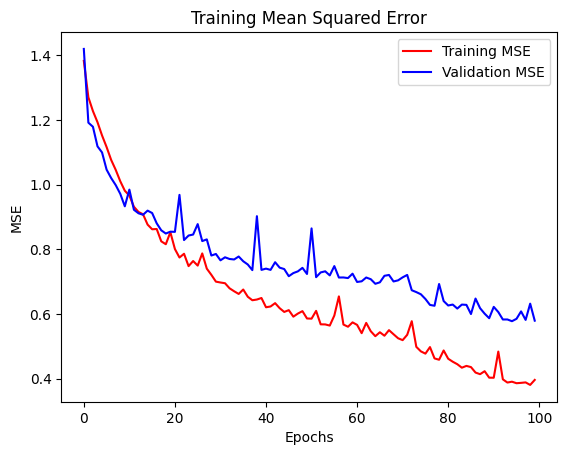

<Figure size 640x480 with 0 Axes>

In [38]:
# Plotting the training and validation loss

import matplotlib.pyplot as plt

mse = history.history['mse']
val_mse = history.history['val_mse']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mse))

plt.plot(epochs, mse, 'r')
plt.plot(epochs, val_mse, 'b')
plt.title('Training and Validation MSE')
plt.title('Training Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.figure()

In [39]:
# Saving the trained model
model.save("DTBA_model.keras")

In [40]:
# Reloading the saved model
trained_model = tf.keras.models.load_model("DTBA_model.keras")
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1382)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 72, 128)              5632      ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1382, 128)            2688      ['input_2[0][0]']             
                                                                                              

## Testing the model

In [41]:
import requests

# Function to fetch protein sequences from UniProt
def fetch_protein_sequences(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        # Extract the sequence from the FASTA format
        sequence_lines = response.text.split("\n")[1:]
        sequence = "".join(sequence_lines)
    return sequence

In [42]:
#Fetching protein sequence for PI3K using UNIPROT ID
target_seq = fetch_protein_sequences('P42336')
len(target_seq)

1068

In [43]:
#Set of drugs similar in structure to Copanlisib (PI3K inhibitor) obtained from nference small molecules app
drugs_df = pd.read_csv("Copanlisib_Similar_Drugs.csv")
drugs_df.head(2)

,Drug_ID,Drug Name,SMILES
0,npc_135565785,COPANLISIB HYDROCHLORIDE,COC1=C(C=CC2=C3NCCN3C(=NC(=O)C4=CN=C(N=C4)N)N=...
1,npc_135905473,BAY-1082439,CC1=C(C=CC=N1)C(=O)N=C2N=C3C(=C4N2CCN4)C=CC(=C...


In [44]:
drugs_smiles = drugs_df.SMILES.to_list()
target_sequence = []
for i in range(len(drugs_smiles)):
    target_sequence.append(target_seq)

In [45]:
#Preprocessing the ligands and target
def preprocessing_inputs(target,drugs):
    target = tokenizer_proteins.texts_to_sequences(target)
    target = pad_sequences(target,truncating="post",padding="post",maxlen=int(max_seq_len))
    target = np.array(target)

    drugs = tokenizer_smiles.texts_to_sequences(drugs)
    drugs = pad_sequences(drugs,truncating="post",padding="post",maxlen=int(max_smiles_len))
    drugs = np.array(drugs)

    return target, drugs

In [46]:
target, drugs = preprocessing_inputs(target_sequence,drugs_smiles)

In [47]:
target.shape, drugs.shape

((72, 1382), (72, 72))

In [48]:
# Prediction of KiBA score for the set of drugs against PI3K
kiba_predictions = trained_model.predict([drugs,target])

3/3 [==============================] - 2s 56ms/step


In [49]:
drugs_df['KiBA_Predictions'] = kiba_predictions

In [50]:
#Sorting the values and displaying the top 10 ligands with the lowest KiBA scores (highest affinity)
drugs_kiba_predicted = drugs_df[['Drug Name','KiBA_Predictions']]\
                            .sort_values('KiBA_Predictions').\
                            reset_index(drop=True)
drugs_kiba_predicted.head(10)

,Drug Name,KiBA_Predictions
0,SAPITINIB,0.729892
1,4SC-203,0.962286
2,FGF401,0.967848
3,AZD-7986,1.010535
4,BRILACIDIN,1.127901
5,SAR-260301,1.229122
6,UK432097,1.348650
7,PAMAPIMOD,1.430524
8,LAZERTINIB,1.474842
9,RODATRISTAT ETHYL,1.517885
